In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from scipy.signal import butter, filtfilt, convolve2d

In [193]:
file_path_1 = "BCICIV_1_mat/BCICIV_calib_ds1a"

In [194]:
class Dataset:
    def __init__(self,
                 file_path,
                 window_start_point = 0.5,
                 window_end_point = 2.5):
        self.data = loadmat(file_name=file_path)
        self.window_start_point = window_start_point
        self.window_end_point = window_end_point
        self.sampling_frequency = self.data['nfo']['fs'][0][0][0][0]
        self.EEGsignal = self.data['cnt'].T
        self.n_channels, self.n_samples = self.EEGsignal.shape
        self.trial_onsets = self.data['mrk'][0][0][0]
        self.trial_codes = self.data['mrk'][0][0][1]
        self.labels = np.zeros(self.n_samples)
        self.labels[self.trial_onsets] = self.trial_codes
        self.class_labels = [x[0] for x in self.data['nfo']['classes'][0][0][0]]
        self.n_classes = len(self.class_labels)
        self.n_trails = len(self.trial_onsets)
        self.window = np.arange(int(self.window_start_point*self.sampling_frequency), int(self.window_end_point*self.sampling_frequency))
        self.n_samples_per_trail = len(self.window)
        self.trials = {}
        for label, code in zip(self.class_labels, np.unique(self.trial_codes)):
            class_onsets = self.trial_onsets[self.trial_codes == code]
            self.trials[label] = np.zeros((len(class_onsets), self.n_channels, self.n_samples_per_trail))
            for i, oneset in enumerate(class_onsets):
                self.trials[label][i, :, :] = self.EEGsignal[:, self.window + oneset]        

    def butter_band_pass(self,
                  low_cut,
                  high_cut,
                  order):
        
        nyq = 0.5*self.sampling_frequency
        low = low_cut / nyq
        high = high_cut / nyq
        return butter(order, [low, high], btype='band')
    
    def bandpass_filter(self,
                        data,
                        low_cut=8,
                        high_cut=30,
                        order = 3):
        b, a = self.butter_band_pass(low_cut=low_cut,
                                     high_cut=high_cut,
                                     order=order)
        return filtfilt(b = b,
                        a = a,
                        x=data, 
                        axis=0)

    def CAR_filter(self,
                   data):
        return data - np.mean(data, axis=0)
    
    def laplacian_filter(self, 
                         data):
        
        laplacian_kernel = np.array([[0, 1, 0],
                                    [1, -4, 1],
                                    [0, 1, 0]])

        laplacian_kernel = laplacian_kernel - np.mean(laplacian_kernel)
        return convolve2d(data, laplacian_kernel, mode='same', boundary='symm')
        

    #PCA ICA TODO?    

        
    
        

In [195]:
a = Dataset(file_path_1)
data_ = a.trials['foot'][0]

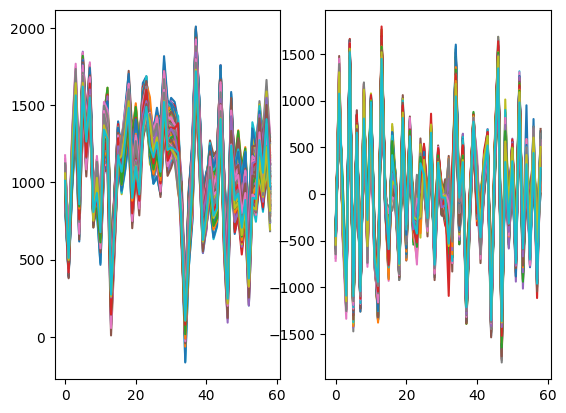

In [197]:
transformed = a.laplacian_filter(data_)
plt.subplot(1, 2, 1)
plt.plot(data_)
plt.subplot(1, 2, 2)
plt.plot(transformed)
plt.show()